# Import basic library

In [1]:
# %% load libraries
import os
import numpy as np
from scipy import spatial
import pandas as pd
import spacy
import en_core_web_lg
#import tomotopy as tp
import re
import matplotlib.pyplot as plt

In [2]:
# %% initialize a spaCy's pipeline
nlp = en_core_web_lg.load()

# Building semantic axis for sentiment analysis

In [3]:
# load General Inquirer categories of words

df = pd.read_excel("inquireraugmented.xls", usecols=["Entry", "Positiv", "Negativ",'Pain','Pleasur','Power','Submit'])

In [4]:
# custom function that creates a semantic axis
positive = df.loc[df["Positiv"].notnull(), "Entry"].apply(str).to_list()
negative = df.loc[df["Negativ"].notnull(), "Entry"].apply(str).to_list()
pain = df.loc[df["Pain"].notnull(), "Entry"].apply(str).to_list()
pleasure = df.loc[df["Pleasur"].notnull(), "Entry"].apply(str).to_list()
power = df.loc[df["Power"].notnull(), "Entry"].apply(str).to_list()
submit = df.loc[df["Submit"].notnull(), "Entry"].apply(str).to_list()

In [5]:
# example
positive

['ABIDE',
 'ABILITY',
 'ABLE',
 'ABOUND',
 'ABSOLVE',
 'ABSORBENT',
 'ABSORPTION',
 'ABUNDANCE',
 'ABUNDANT',
 'ACCEDE',
 'ACCENTUATE',
 'ACCEPT',
 'ACCEPTABLE',
 'ACCEPTANCE',
 'ACCESSIBLE',
 'ACCESSION',
 'ACCLAIM',
 'ACCLAMATION',
 'ACCOLADE',
 'ACCOMMODATE',
 'ACCOMMODATION',
 'ACCOMPANIMENT',
 'ACCOMPLISH',
 'ACCOMPLISHMENT',
 'ACCORD#2',
 'ACCORD#3',
 'ACCORD#5',
 'ACCORDANCE',
 'ACCOUNTABLE',
 'ACCRUE',
 'ACCURACY',
 'ACCURATE',
 'ACCURATENESS',
 'ACHIEVE',
 'ACHIEVEMENT',
 'ACKNOWLEDGEMENT',
 'ACQUAINT',
 'ACQUAINTANCE',
 'ACQUIT',
 'ACQUITTAL',
 'ACTUAL#1',
 'ACTUAL#2',
 'ACTUALITY',
 'ADAMANT',
 'ADAPTABILITY',
 'ADAPTABLE',
 'ADAPTATION',
 'ADAPTIVE',
 'ADEPT',
 'ADEPTNESS',
 'ADEQUATE',
 'ADHERENCE',
 'ADHERENT',
 'ADHESION',
 'ADHESIVE',
 'ADJUNCT',
 'ADJUST#2',
 'ADJUSTABLE',
 'ADJUSTMENT',
 'ADMIRABLE',
 'ADMIRATION',
 'ADMIRE',
 'ADMIRER',
 'ADMIT#1',
 'ADMIT#2',
 'ADMIT#3',
 'ADMITTANCE',
 'ADORABLE',
 'ADORE',
 'ADORN',
 'ADORNMENT',
 'ADROIT',
 'ADROITLY',
 'ADULATIO

In [6]:
# cleaning
def clean(word_):
    return word_.lower().split("#")[0]

In [7]:
positive = [clean(word) for word in positive]
negative = [clean(word) for word in negative]
pain = [clean(word) for word in pain]
pleasure = [clean(word) for word in pleasure]
power = [clean(word) for word in power]
submit = [clean(word) for word in submit]

In [8]:
# get the affect score for a sample of unseen words
def semantic_ax(word_list, vector_len=300):
    wv = {}
    # get the word vectors
    for word in word_list:
        wv[word] = nlp.vocab[word].vector
    # get the centroid of each pole
    centroid = []
    for i in range(vector_len):
        dimension = [wv[word][i] for word in wv.keys()]
        centroid.extend([np.mean(dimension)])
    # return data
    return wv, np.array(centroid)

In [9]:
# apply the function
positive_wv, positive_centroid = semantic_ax(positive)
negative_wv, negative_centroid = semantic_ax(negative)
pain_wv, pain_centroid = semantic_ax(pain)
pleasure_wv, pleasure_centroid = semantic_ax(pleasure)
power_wv, power_centroid = semantic_ax(power)
submit_wv, submit_centroid = semantic_ax(submit)

# get the semantic axis
my_ax = positive_centroid + pleasure_centroid + power_centroid - submit_centroid - negative_centroid - pain_centroid

# Data preparation

In [11]:
# Import data and sort by time
data = pd.read_csv('Uberpeople_review.csv', index_col=0)
data = data.sort_values('review_dates').reset_index(drop = True)

In [12]:
# show the data
pd.set_option('display.max_colwidth', None)
data

,review,review_dates
0,"paulbernard said:Sometimes when I'm completing what I hope will be my last trip of the day, I'll receive a request. If I go offline while I have passengers on board, will that screw up the trip in progress? I don't like to decline requests, but there are times when I'm ready to call it quits. Thanks for any reply.Click to expand...-------------------------If you are driving Lyft -- the LOG ON button at the top of screen - tap it and push "" last ride"". You will get no further calls. If you are on a ""shared"" trip, the new calls will stop when the last ""Shared trip "" ends.",2020-02-29T15:35:54-0500
1,"SHalester said:aren't those limited how many you can use and time? I tried it first month I drove, found it useless.Click to expand...Yes, to two a day. I do one to work in the morning and one at night. The filter stays on until the time runs out or I reach my destination, whichever comes first. It doesn't limit you to one ride per filter, you can do as many as you can fit in/they give you, as long as you don't go offline or ""stop new requests"". Every once in a while, I'll get zero rides. Usually I get one to two in each direction - but sometimes I can get four or five (especially on my way home from work on a Friday night, since I live in the city itself).",2020-02-29T15:35:54-0500
2,This is a sarcasm free zone. Really. No kidding. Seriously. Why are you looking at me like that? Why don't you believe me? 🙄,2020-02-29T15:35:54-0500
3,"[email protected] said:I only drive on destination filterClick to expand...aren't those limited how many you can use and time? I tried it first month I drove, found it useless.",2020-02-29T15:35:54-0500
4,"There is a city north of Miami called Fort Lauderdale. If you have friends there, try staying with them. Rent your Miami place out, make monster $$$$$. If you feel the need to drive, you may have people in Fort Lauderdale that is heading down to this event and you will definitely make more money on the long trip hauls down and who knows, with the peak vacation traffic, as well as the event, you may hit a few good surges.",2020-02-29T16:25:15-0500
...,...,...
60006,"teh744 said:I noticed that last summer. Lyft doesn't do prime time pricing anymore where I'm at. I was getting 25-30 min pings. Screw that! Uber had a $10-15 surge going on....I will take that!Some pax were complaining to me on fact that there are few Lyft drivers. I told them that I was getting unprofitable rides from them(25 min away, 4 min trip, no prime time). So I quit taking rides from them. Most drivers where I'm at, usually drive for both. With a $10-15 surge going on, I can make a lot more. Most saw where I was coming from. Some felt I was cheating the system. I told them it was basic economics... $20 for a 5 min ride(Uber) or $5 for a 20 min ride(Lyft).Click to expand...Cheating the system? Let me guess you are cheating by not taking that 25+ minute away $3.50 ride they requested, right???",2021-07-12T12:21:28-0400
60007,May you live in interesting times,2021-07-12T12:21:28-0400
60008,"Uber/Lyft was never my primary source of income. I do have to say I'm tired of the pay cuts. I'm done beating up my car for what rideshare pays. I've driven very little in the last year and not at all since the beginning of Nov.. If people want the convenience of a car being there within a couple of minutes then it's time to start paying for it or I won't be back....hell, I probably won't be back at all.",2021-07-12T12:21:28-0400
60009,"wallae said:Well I hope the rides are real spread out thereI would not want him to feel in adequate by only being able to take 10 and 15 minute pick upsClick to expand...ohhhh, Tucson has an ""uber shorage"" but....NO shortage of 25-30 min pings, only that during daylight hours he'd be competing for them with the legions of elderly male snowbird hobby drivers who get a few hours out of the house to score a decaf and a donut, and do a few ""anywhere, any place, anyone type of PUs"" for

In [13]:
# apply string
data['review'] = data['review'].apply(str)

In [14]:
# drop the "nan" review
data = data[data['review']!= 'nan'].reset_index(drop= True)

In [15]:
# import nltk
from nltk.corpus import stopwords
from nltk.util import bigrams

In [16]:
#eng_stop_words
eng_stop_words = stopwords.words('english')

In [17]:
# text cleaning function
def clean_text(text, unigrams = True):
    # lower case
    text = text.lower()
    # remove click to expand
    text = re.sub("click to expand", " ", text)
    # remove digits
    text = re.sub("\d+", " ", text)
    # remove punctuation
    text = re.sub(' +', ' ', re.sub(r'[^\w\s]',' ',text))
    # split words
    text = ' '.join([word for word in text.split() if word not in eng_stop_words])
    # get lemma and tokenize
    tokens = [token.lemma_ for token in nlp(text)
              if not token.is_stop]
    if unigrams == False:
    # Tokenize texts into bigrams
        tokens = [''.join(bigram) for bigram in bigrams(tokens)]
    return tokens

In [18]:
# Clean the data
data_cleaned = data['review'].apply(clean_text)
data_cleaned

0                                                                                                                                                                                              [paulbernard, say, complete, hope, trip, day, receive, request, offline, passenger, board, screw, trip, progress, like, decline, request, time, ready, quit, thank, reply, drive, lyft, log, button, screen, tap, push, ride, call, share, trip, new, call, stop, share, trip, end]
1                                                                                                                                                          [shalester, say, limit, use, time, try, month, drive, find, useless, yes, day, work, morning, night, filter, stay, time, run, reach, destination, whichever, come, limit, ride, filter, fit, long, offline, stop, new, request, zero, ride, usually, direction, especially, way, home, work, friday, night, live, city]
2                                                                 

In [19]:
def count_tokens(text, desc=True):
    '''Count the frequency of each word given a list of tokens'''
    word_dict = {}
    
    for line in text:
        for token in line:
            if token in word_dict:
                word_dict[token] += 1
            elif token not in word_dict:
                word_dict[token] = 1
    
    if desc:
        word_dict = sorted(word_dict.items(), 
                           key = lambda entry: entry[1],
                           reverse = True)
    
    return word_dict 

In [20]:
# Find some contextual stop words 
word_count = count_tokens(data_cleaned)
print(word_count[0:100])

[('say', 36340), ('uber', 28278), ('driver', 18691), ('time', 15316), ('get', 13656), ('like', 13507), ('drive', 13260), ('ride', 12739), ('car', 11829), ('know', 11325), ('go', 10478), ('pay', 9958), ('think', 9683), ('work', 8873), ('pax', 7984), ('day', 7921), ('people', 7745), ('lyft', 7582), ('want', 7499), ('app', 7487), ('trip', 7365), ('good', 7327), ('year', 7059), ('way', 6213), ('right', 6055), ('thing', 5827), ('look', 5741), ('try', 5724), ('minute', 5683), ('tell', 5646), ('new', 5558), ('hour', 5400), ('week', 5304), ('mile', 5284), ('need', 5255), ('money', 5189), ('stop', 5115), ('long', 5004), ('use', 4928), ('ask', 4766), ('find', 4692), ('start', 4683), ('take', 4635), ('come', 4628), ('market', 4626), ('wait', 4501), ('different', 4480), ('rate', 4218), ('account', 4216), ('job', 4067), ('tip', 4019), ('phone', 3978), ('state', 3971), ('pick', 3775), ('passenger', 3762), ('cancel', 3749), ('check', 3745), ('rider', 3730), ('surge', 3717), ('help', 3620), ('free', 3

In [21]:
# select the stopwords mannually
context_sw=['say','uber','www','https','com']
# remove stopwords
corpus = data_cleaned.apply(lambda line: [token for token in line if token not in context_sw])
print(corpus[0:5])

0                                        [paulbernard, complete, hope, trip, day, receive, request, offline, passenger, board, screw, trip, progress, like, decline, request, time, ready, quit, thank, reply, drive, lyft, log, button, screen, tap, push, ride, call, share, trip, new, call, stop, share, trip, end]
1    [shalester, limit, use, time, try, month, drive, find, useless, yes, day, work, morning, night, filter, stay, time, run, reach, destination, whichever, come, limit, ride, filter, fit, long, offline, stop, new, request, zero, ride, usually, direction, especially, way, home, work, friday, night, live, city]
2                                                                                                                                                                                                                                                            [sarcasm, free, zone, kid, seriously, look, like, believe]
3                                                               

In [22]:
# Drop those empty cells
drop_list = [i for i, c in zip(corpus.index, corpus) if len(c) ==0]
corpus_1 = corpus.drop(drop_list)
print(f'Length of drop_list:{len(drop_list)}; previous length:{len(corpus)}; current length:{len(corpus_1)}')

Length of drop_list:389; previous length:59307; current length:58918


# Sentiment Analysis

In [23]:
# show the words that don't have word vector and would cause the 'nan'; It can be used to check if the corpus is cleaned.
na_list = []
count_none = 0
for c in corpus_1:
    word_list = c
    #pos_list= []
    for word in word_list:
        vector = nlp.vocab[word].vector
        pos = 1 - spatial.distance.cosine(my_ax, vector)
            #pos_list.append(pos)
        if np.isnan(pos):
            na_list.append(word)
na_list # turn out it is clean: no punctuation or number in the token

/Users/houhungliu/opt/anaconda3/envs/NLP/lib/python3.7/site-packages/scipy/spatial/distance.py:728: RuntimeWarning: invalid value encountered in float_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


['paulbernard',
 'lyft',
 'shalester',
 'ylinks',
 'towrd',
 'ylinks',
 'iann',
 'lyft',
 'banksmy',
 'keybank',
 'keybank',
 'firstbank',
 'keybank',
 'lyft',
 'firstbank',
 'lyft',
 'keybank',
 'keybank',
 'lyft',
 'keybank',
 'keybank',
 'keybank',
 'keybank',
 'reynob',
 'delornick',
 'reynob',
 'reynob',
 'deprioiritise',
 'doordash',
 'poppedup',
 'wheneverso',
 'poppedup',
 'wheneverso',
 'misidentifie',
 'uberadrian',
 'crossedthank',
 'uberpeople',
 'hopephone',
 'xorbust',
 'hopeps',
 'uberadrian',
 'misidentifie',
 'trafficat',
 'losiglow',
 'uberpeople',
 'dctcmn',
 'undergeographical',
 'houstonye',
 'christinebitg',
 'undergeographical',
 'houstonye',
 'mygovernmentonline',
 'swathdiver',
 'democratnot',
 'mdnkln',
 'bigbadbob',
 'ntcindetroit',
 'mdnkln',
 'uberx',
 'ubereat',
 'lyft',
 'uberlaguy',
 'lyft',
 'lyft',
 'mdnkln',
 'steve_tx',
 'lowcountryyo',
 'gryft',
 'gryft',
 'gryft',
 'gryft',
 'somoe',
 'lyft',
 'lyft',
 'lyft',
 'byrt',
 'oldfart',
 'milesi',
 'foun

In [24]:
# get the sentiment position of a word list
def get_position(word_list, my_ax):
    pos_list= []
    for word in word_list:
        vector = nlp.vocab[word].vector
        # if vector is a zero array, skip
        if all(np.zeros((300,))==vector):
            continue
        else:
            # cosine similarity
            pos = 1 - spatial.distance.cosine(my_ax, vector)
            pos_list.append(pos)
    # if the pos_list is empty
    if len(pos_list)==0:
        sent = 'empty'
    else:
        # the mean, ignore nan
        sent = np.nansum(pos_list)/len(pos_list)
    return sent

In [25]:
sentiment = corpus_1.apply(lambda x: get_position(x, my_ax))
sentiment

0        0.077713
1        0.076791
2        0.013693
3        0.070183
4        0.078518
           ...   
59302    0.016287
59303    0.127437
59304    0.030293
59305    0.041878
59306    0.015536
Name: review, Length: 58918, dtype: object

In [63]:
# remove the 'empty' caused by unrecognised worda
sentiment = sentiment[sentiment!='empty']
# get the index of the sentiment_list
s_index = sentiment.index
s_index

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            59297, 59298, 59299, 59300, 59301, 59302, 59303, 59304, 59305,
            59306],
           dtype='int64', length=58785)

In [26]:
# any na left?
na_position = np.where(sentiment.isna())[0]
na_position

array([], dtype=int64)

In [75]:
# make a new list for it
# sentiment_list = [s for s in sentiment if s!='empty' ]
sentiment_list = sentiment.apply(float).to_frame('sentiment_score')
sentiment_list

,sentiment_score
0,0.077713
1,0.076791
2,0.013693
3,0.070183
4,0.078518
...,...
59302,0.016287
59303,0.127437
59304,0.030293
59305,0.041878


In [106]:
sentiment_list.describe()

/Users/houhungliu/opt/anaconda3/envs/NLP/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,sentiment_score
count,58785.000000
mean,0.033309
std,0.050093
min,-0.300198
25%,0.011632
50%,0.037911
75%,0.064457
max,0.292673


## Preparation for Sentiment Affective States Analysis and Topic Modeling

In [77]:
# drop the empty index of sentiment list
'''
These comments only contains words that are unrecognised by spacy
'''
data_1 = data.loc[s_index,]
data_cleaned_1 = data_cleaned[s_index]

In [80]:
# select the stopwords mannually
context_sw=['say','uber','www','https','com','click','expand']
#context_sw = [word[0] for word in word_count[0:21]] # remove words until SQL
corpus_2 = data_cleaned_1.apply(lambda line: [token for token in line if token not in context_sw])
print(corpus_2[0:5])

0                                        [paulbernard, complete, hope, trip, day, receive, request, offline, passenger, board, screw, trip, progress, like, decline, request, time, ready, quit, thank, reply, drive, lyft, log, button, screen, tap, push, ride, call, share, trip, new, call, stop, share, trip, end]
1    [shalester, limit, use, time, try, month, drive, find, useless, yes, day, work, morning, night, filter, stay, time, run, reach, destination, whichever, come, limit, ride, filter, fit, long, offline, stop, new, request, zero, ride, usually, direction, especially, way, home, work, friday, night, live, city]
2                                                                                                                                                                                                                                                            [sarcasm, free, zone, kid, seriously, look, like, believe]
3                                                               

In [81]:
# Drop those empty cells
drop_list_2 = [i for i, c in zip(corpus_2.index, corpus_2) if len(c) ==0]
corpus_3 = corpus_2.drop(drop_list_2)#.reset_index(drop=True)
print(f'Length of drop_list:{len(drop_list_2)}; previous length:{len(corpus_2)}; current length:{len(corpus_3)}')

Length of drop_list:0; previous length:58785; current length:58785


# Data visualisation for Sentiment Affective States

In [33]:
# library to explore date data
import datetime

In [90]:
# make a copy of data_1
data_2= data_1.copy()
# split the review_dates into year and month and create columns
data_2[['date','time']] = data_2['review_dates'].str.split('T', expand=True)
data_2[['year','month', 'day']] = data_2['date'].str.split('-', expand=True)
data_2

,review,review_dates,date,time,year,month,day
0,"paulbernard said:Sometimes when I'm completing what I hope will be my last trip of the day, I'll receive a request. If I go offline while I have passengers on board, will that screw up the trip in progress? I don't like to decline requests, but there are times when I'm ready to call it quits. Thanks for any reply.Click to expand...-------------------------If you are driving Lyft -- the LOG ON button at the top of screen - tap it and push "" last ride"". You will get no further calls. If you are on a ""shared"" trip, the new calls will stop when the last ""Shared trip "" ends.",2020-02-29T15:35:54-0500,2020-02-29,15:35:54-0500,2020,02,29
1,"SHalester said:aren't those limited how many you can use and time? I tried it first month I drove, found it useless.Click to expand...Yes, to two a day. I do one to work in the morning and one at night. The filter stays on until the time runs out or I reach my destination, whichever comes first. It doesn't limit you to one ride per filter, you can do as many as you can fit in/they give you, as long as you don't go offline or ""stop new requests"". Every once in a while, I'll get zero rides. Usually I get one to two in each direction - but sometimes I can get four or five (especially on my way home from work on a Friday night, since I live in the city itself).",2020-02-29T15:35:54-0500,2020-02-29,15:35:54-0500,2020,02,29
2,This is a sarcasm free zone. Really. No kidding. Seriously. Why are you looking at me like that? Why don't you believe me? 🙄,2020-02-29T15:35:54-0500,2020-02-29,15:35:54-0500,2020,02,29
3,"[email protected] said:I only drive on destination filterClick to expand...aren't those limited how many you can use and time? I tried it first month I drove, found it useless.",2020-02-29T15:35:54-0500,2020-02-29,15:35:54-0500,2020,02,29
4,"There is a city north of Miami called Fort Lauderdale. If you have friends there, try staying with them. Rent your Miami place out, make monster $$$$$. If you feel the need to drive, you may have people in Fort Lauderdale that is heading down to this event and you will definitely make more money on the long trip hauls down and who knows, with the peak vacation traffic, as well as the event, you may hit a few good surges.",2020-02-29T16:25:15-0500,2020-02-29,16:25:15-0500,2020,02,29
...,...,...,...,...,...,...,...
59302,"teh744 said:I noticed that last summer. Lyft doesn't do prime time pricing anymore where I'm at. I was getting 25-30 min pings. Screw that! Uber had a $10-15 surge going on....I will take that!Some pax were complaining to me on fact that there are few Lyft drivers. I told them that I was getting unprofitable rides from them(25 min away, 4 min trip, no prime time). So I quit taking rides from them. Most drivers where I'm at, usually drive for both. With a $10-15 surge going on, I can make a lot more. Most saw where I was coming from. Some felt I was cheating the system. I told them it was basic economics... $20 for a 5 min ride(Uber) or $5 for a 20 min ride(Lyft).Click to expand...Cheating the system? Let me guess you are cheating by not taking that 25+ minute away $3.50 ride they requested, right???",2021-07-12T12:21:28-0400,2021-07-12,12:21:28-0400,2021,07,12
59303,May you live in interesting times,2021-07-12T12:21:28-0400,2021-07-12,12:21:28-0400,2021,07,12
59304,"Uber/Lyft was never my primary source of income. I do have to say I'm tired of the pay cuts. I'm done beating up my car for what rideshare pays. I've driven very little in the last year and not at all since the beginning of Nov.. If people want the convenience of a car being there within a couple of minutes then it's time to start paying for it or I won't be back....hell, I probably won't be back at all.",2021-07-12T12:21:28-0400,2021-07-12,12:21:28-0400,2021,07,12
59305,"wallae said:Well I hope the rides are real spread out thereI would not want him to feel in adequate by only being able to take 10 and 15 minute pick upsClic

## Merge the sentiment list with data

In [91]:
data_2 = data_2.merge(sentiment_list, left_index=True, right_index=True)
# data_2.rename(columns={0: 'sentiment'}, inplace=True)
data_2

,review,review_dates,date,time,year,month,day,sentiment_score
0,"paulbernard said:Sometimes when I'm completing what I hope will be my last trip of the day, I'll receive a request. If I go offline while I have passengers on board, will that screw up the trip in progress? I don't like to decline requests, but there are times when I'm ready to call it quits. Thanks for any reply.Click to expand...-------------------------If you are driving Lyft -- the LOG ON button at the top of screen - tap it and push "" last ride"". You will get no further calls. If you are on a ""shared"" trip, the new calls will stop when the last ""Shared trip "" ends.",2020-02-29T15:35:54-0500,2020-02-29,15:35:54-0500,2020,02,29,0.077713
1,"SHalester said:aren't those limited how many you can use and time? I tried it first month I drove, found it useless.Click to expand...Yes, to two a day. I do one to work in the morning and one at night. The filter stays on until the time runs out or I reach my destination, whichever comes first. It doesn't limit you to one ride per filter, you can do as many as you can fit in/they give you, as long as you don't go offline or ""stop new requests"". Every once in a while, I'll get zero rides. Usually I get one to two in each direction - but sometimes I can get four or five (especially on my way home from work on a Friday night, since I live in the city itself).",2020-02-29T15:35:54-0500,2020-02-29,15:35:54-0500,2020,02,29,0.076791
2,This is a sarcasm free zone. Really. No kidding. Seriously. Why are you looking at me like that? Why don't you believe me? 🙄,2020-02-29T15:35:54-0500,2020-02-29,15:35:54-0500,2020,02,29,0.013693
3,"[email protected] said:I only drive on destination filterClick to expand...aren't those limited how many you can use and time? I tried it first month I drove, found it useless.",2020-02-29T15:35:54-0500,2020-02-29,15:35:54-0500,2020,02,29,0.070183
4,"There is a city north of Miami called Fort Lauderdale. If you have friends there, try staying with them. Rent your Miami place out, make monster $$$$$. If you feel the need to drive, you may have people in Fort Lauderdale that is heading down to this event and you will definitely make more money on the long trip hauls down and who knows, with the peak vacation traffic, as well as the event, you may hit a few good surges.",2020-02-29T16:25:15-0500,2020-02-29,16:25:15-0500,2020,02,29,0.078518
...,...,...,...,...,...,...,...,...
59302,"teh744 said:I noticed that last summer. Lyft doesn't do prime time pricing anymore where I'm at. I was getting 25-30 min pings. Screw that! Uber had a $10-15 surge going on....I will take that!Some pax were complaining to me on fact that there are few Lyft drivers. I told them that I was getting unprofitable rides from them(25 min away, 4 min trip, no prime time). So I quit taking rides from them. Most drivers where I'm at, usually drive for both. With a $10-15 surge going on, I can make a lot more. Most saw where I was coming from. Some felt I was cheating the system. I told them it was basic economics... $20 for a 5 min ride(Uber) or $5 for a 20 min ride(Lyft).Click to expand...Cheating the system? Let me guess you are cheating by not taking that 25+ minute away $3.50 ride they requested, right???",2021-07-12T12:21:28-0400,2021-07-12,12:21:28-0400,2021,07,12,0.016287
59303,May you live in interesting times,2021-07-12T12:21:28-0400,2021-07-12,12:21:28-0400,2021,07,12,0.127437
59304,"Uber/Lyft was never my primary source of income. I do have to say I'm tired of the pay cuts. I'm done beating up my car for what rideshare pays. I've driven very little in the last year and not at all since the beginning of Nov.. If people want the convenience of a car being there within a couple of minutes then it's time to start paying for it or I won't be back....hell, I probably won't be back at all.",2021-07-12T12:21:28-0400,2021-07-12,12:21:28-0400,2021,07,12,0.030293
59305,"wallae said:Well I hope the rides are real spread out thereI wou

## Analyze the year-month data

In [97]:
data_3 = data_2.groupby(['year','month']).mean().reset_index()
# merge the year and month into one column
data_3['Date']=data_3['year'].astype(str) + '-'+ data_3['month'].astype(str).str.zfill(2)
data_3

,year,month,sentiment_score,Date
0,2020,02,0.047049,2020-02
1,2020,03,0.029151,2020-03
2,2020,04,0.033527,2020-04
3,2020,05,0.036239,2020-05
4,2020,06,0.035142,2020-06
5,2020,07,0.036499,2020-07
6,2020,08,0.033072,2020-08
7,2020,09,0.034483,2020-09
8,2020,10,0.037854,2020-10
9,2020,11,0.036139,2020-11


## Evolution of Uber forum sentiment by month

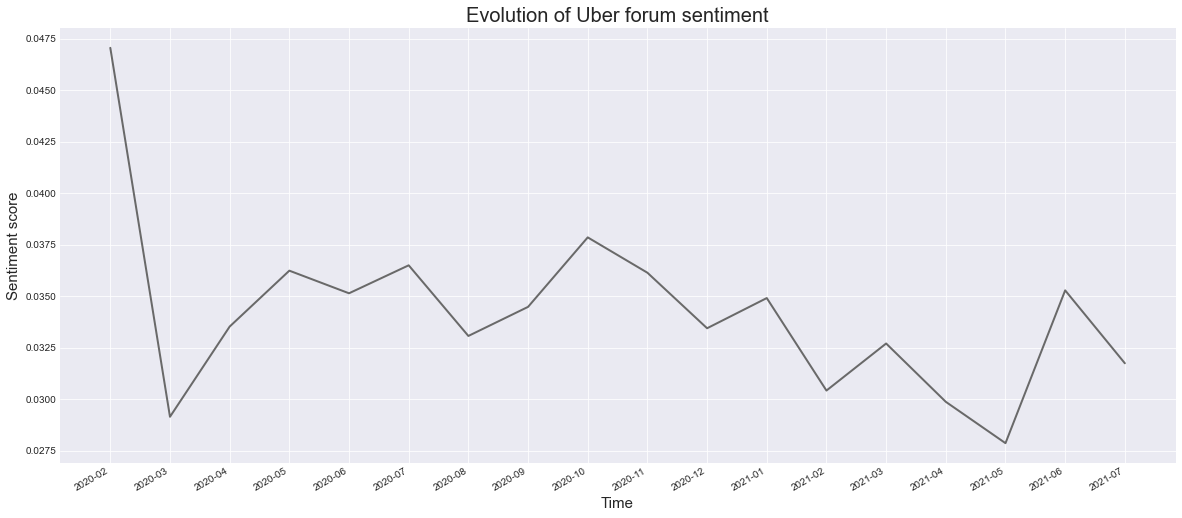

In [99]:
fig, ax = plt.subplots(figsize=(20, 8))
# style
plt.style.use('seaborn-darkgrid')
plt.plot(data_3['Date'],data_3['sentiment_score'],marker='',color='dimgrey', linewidth=2)
plt.title('Evolution of Uber forum sentiment',fontsize=20)
plt.xlabel('Time',fontsize=15)
plt.ylabel('Sentiment score',fontsize=15)
# xticklabels
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
# show
plt.show()

## Analyze the whole data on daily basis

In [100]:
# daily average sentiment scores
data_4 = data_2.groupby(['year','month','day']).mean().reset_index()
# get the dates
data_4['dateInt']=data_4['year'].astype(str) + data_4['month'].astype(str).str.zfill(2) +data_4['day'].astype(str).str.zfill(2)
# date format
data_4['Date'] = pd.to_datetime(data_4['dateInt'], format='%Y%m%d')
data_4

,year,month,day,sentiment_score,dateInt,Date
0,2020,02,29,0.047049,20200229,2020-02-29
1,2020,03,01,0.044149,20200301,2020-03-01
2,2020,03,02,0.035144,20200302,2020-03-02
3,2020,03,03,0.039115,20200303,2020-03-03
4,2020,03,04,0.025262,20200304,2020-03-04
...,...,...,...,...,...,...
477,2021,07,08,0.028126,20210708,2021-07-08
478,2021,07,09,0.026034,20210709,2021-07-09
479,2021,07,10,0.045897,20210710,2021-07-10
480,2021,07,11,0.031825,20210711,2021-07-11


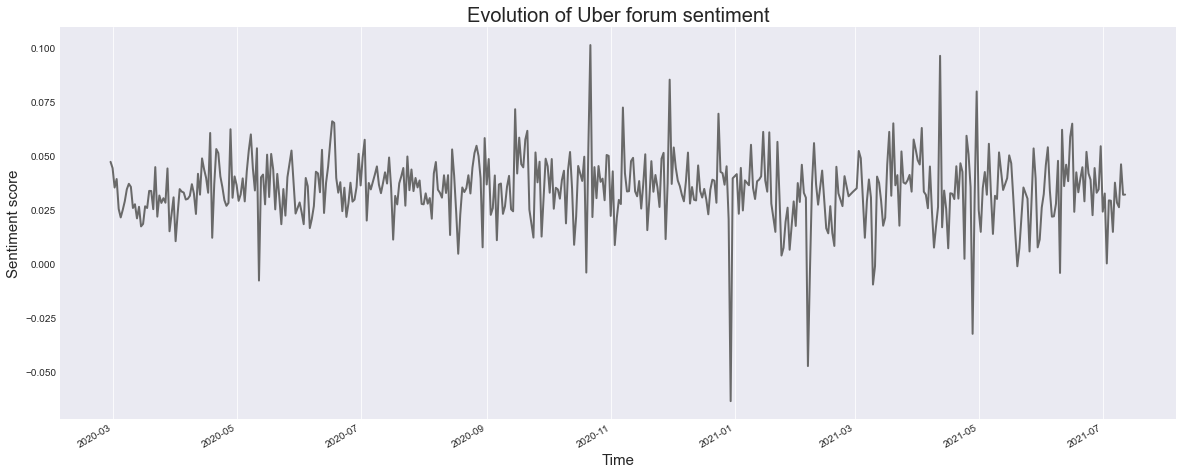

In [101]:
fig, ax = plt.subplots(figsize=(20, 8))

plt.style.use('seaborn-darkgrid')
plt.plot(data_4['Date'],data_4['sentiment_score'],marker='',color='dimgrey', linewidth=2)
plt.title('Evolution of Uber forum sentiment',fontsize=20)
plt.xlabel('Time',fontsize=15)
plt.ylabel('Sentiment score',fontsize=15)
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
# autofit xtick
plt.gcf().autofmt_xdate()
ax.grid(axis='y', ls='--')
plt.show()

## Compare sentiment from 2021 April to June

In [102]:
data_5 = data_2.groupby(['year','month','day']).mean().reset_index()
data_5 = data_5.loc[(data_5['year'] == '2021') & ((data_5['month'] =='05') |(data_5['month'] =='04') |(data_5['month'] =='06'))]
data_5['dateInt']=data_5['year'].astype(str) + data_5['month'].astype(str).str.zfill(2) +data_5['day'].astype(str).str.zfill(2)
data_5['Date'] = pd.to_datetime(data_5['dateInt'], format='%Y%m%d')
data_5

,year,month,day,sentiment_score,dateInt,Date
382,2021,04,01,0.047796,20210401,2021-04-01
383,2021,04,02,0.045808,20210402,2021-04-02
384,2021,04,03,0.062716,20210403,2021-04-03
385,2021,04,04,0.033244,20210404,2021-04-04
386,2021,04,05,0.031822,20210405,2021-04-05
...,...,...,...,...,...,...
465,2021,06,26,0.022364,20210626,2021-06-26
466,2021,06,27,0.044175,20210627,2021-06-27
467,2021,06,28,0.032741,20210628,2021-06-28
468,2021,06,29,0.034317,20210629,2021-06-29


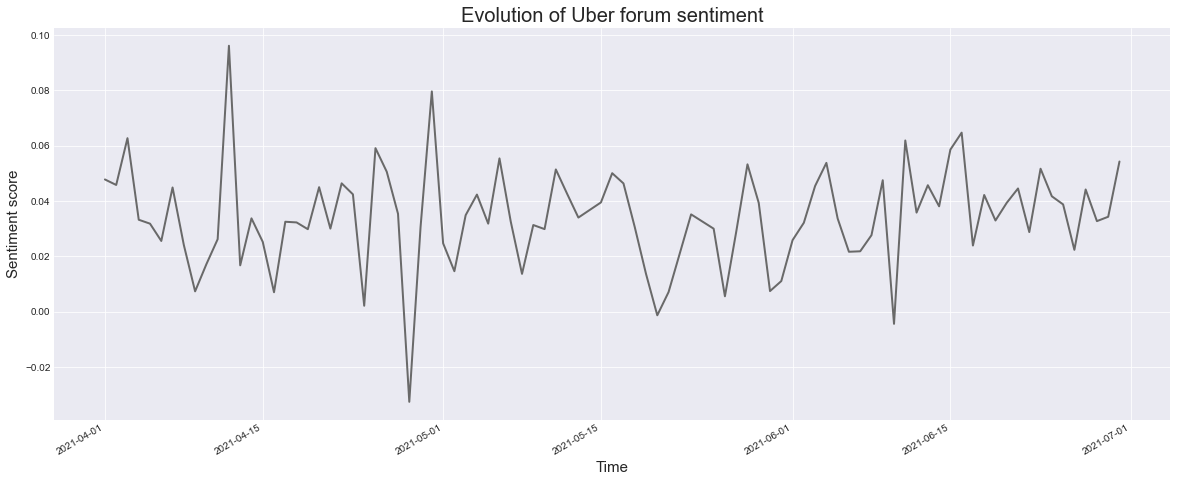

In [104]:
fig, ax = plt.subplots(figsize=(20, 8))

plt.style.use('seaborn-darkgrid')
plt.plot(data_5['Date'],data_5['sentiment_score'],marker='',color='dimgrey', linewidth=2)
plt.title('Evolution of Uber forum sentiment',fontsize=20)
plt.xlabel('Time',fontsize=15)
plt.ylabel('Sentiment score',fontsize=15)
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.gcf().autofmt_xdate()
plt.show()

# Topic Modeling

In [105]:
from gensim.corpora import Dictionary, csvcorpus
from gensim.models.ldamulticore import LdaMulticore
import pyLDAvis
import pyLDAvis.gensim_models

from gensim.models.wrappers import LdaMallet
#os.environ['MALLET_HOME'] = 'C:\\Users\\35196\\mallet-2.0.8'
MALLET_PATH = '/Users/houhungliu/Desktop/mallet-2.0.8/bin/mallet'

import gensim
from gensim.models import LdaModel, ldamodel
from gensim.models import LsiModel, lsimodel
from gensim.models import Phrases
from gensim.models import CoherenceModel  
from gensim.similarities import MatrixSimilarity

## Create dictionary and corpus objects for gensim lda

In [107]:
text_dict = Dictionary(corpus_3)
lda_corpus = [text_dict.doc2bow(text) for text in corpus_3]
print(text_dict)

/Users/houhungliu/opt/anaconda3/envs/NLP/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Dictionary(22124 unique tokens: ['board', 'button', 'call', 'complete', 'day']...)


## Train an LDA model and visualize the result

In [144]:

def plot_top_words(model, num_topics, num_words, title, row_no, column_no, figsize=(20, 30)):
    '''Plot top words of each topic given an LDA model'''
    topics = model.show_topics(num_topics=num_topics, num_words=num_words, formatted=False)
    
    output = []
    for i, topic in topics:
        for word, weight in topic:
            output.append([word, i, weight])
    output = pd.DataFrame(output, columns=['word', 'topic_id', 'importance'])     
       
    fig, axes = plt.subplots(row_no, column_no, figsize=figsize, dpi=160)
    for i, ax in enumerate(axes.flatten()):
        ax.barh(y='word', width="importance", data=output.loc[output.topic_id==i, :], label='Weights')    
        ax.set_title('Topic: ' + str(i+1), fontsize=16)
        ax.invert_yaxis()
            
    fig.tight_layout(w_pad=2) # adjust the width of padding between subplots 
    fig.suptitle(title, fontsize=22, y=1.05)    
    plt.show()

## Using coherance value to select the optimal number of topics

In [109]:
# define function
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    -----------
    dictionary : Gensim dictionary
    corpus     : Gensim corpus
    texts      : List of input texts
    limit      : Max number of topics

    Returns:
    --------
    model_list       : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model
                       with respective number of topics
    """
    coherence_values = []
    model_list = []
    mallet_path = MALLET_PATH
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path,
                                                 corpus=corpus,
                                                 num_topics=num_topics,
                                                 id2word=dictionary,
                                                 random_seed=123)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model,
                                        texts=texts,
                                        dictionary=dictionary,
                                        coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

/Users/houhungliu/opt/anaconda3/envs/NLP/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [110]:
# collect coherence scores as the number of retained topics change
LIMIT, START, STEP = 30, 1, 1
MODEL_LIST, COHER_VALS = compute_coherence_values(dictionary=text_dict ,
                                                  corpus=lda_corpus,
                                                  texts=corpus,
                                                  start=START,
                                                  limit=LIMIT,
                                                  step=STEP)

/Users/houhungliu/opt/anaconda3/envs/NLP/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


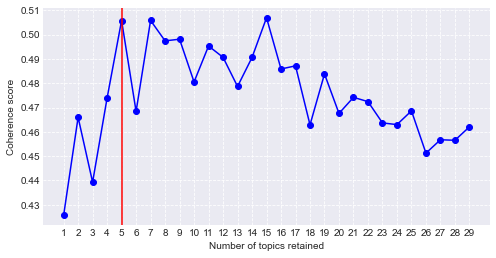

In [142]:
# plot collected coherence scores data

# data series
X = range(START, LIMIT, STEP)
Y = COHER_VALS

# create figure
FIG = plt.figure(figsize=(8, 4))
AX = FIG.add_subplot(1, 1, 1)

# plot data
AX.plot(X, Y, marker='o', color='b', ls='-')

# axes
AX.set_xlabel("Number of topics retained")
AX.set_ylabel("Coherence score")
AX.set_xticks(np.arange(1, 30, 1))

# reference line
AX.axvline(x=5, ymin=0, ymax=1, color='r')

# grid
AX.grid(True, ls='--')


plt.show()

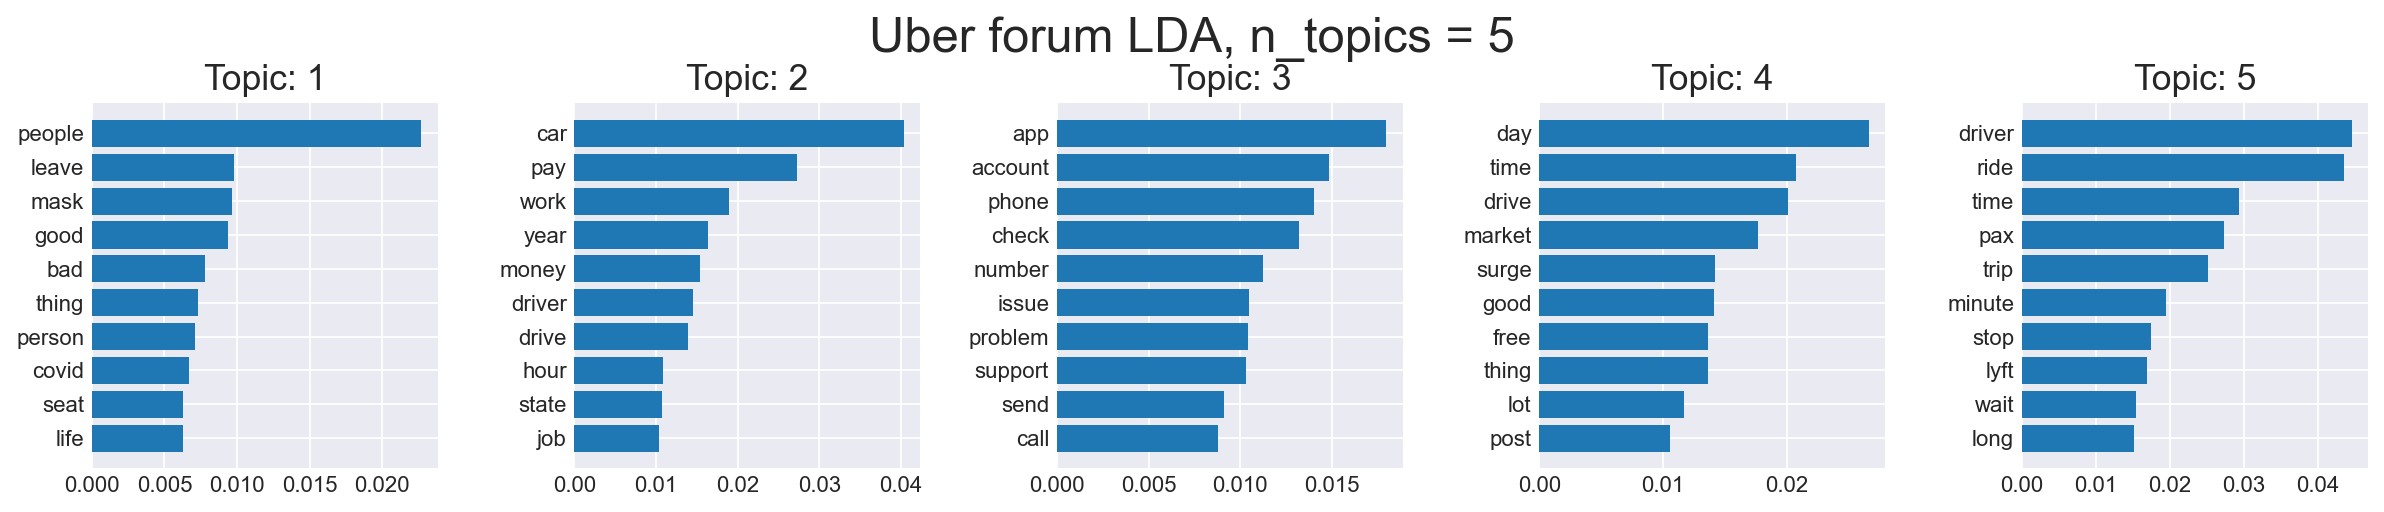

In [148]:
# visualize the most frequent terms for each topic
# select the number of topics as 4 according to the coherence score
num_topics = 5
num_words = 10
row_no = 1
column_no = 5
figsize=(15, 3)
LDA_MALLET = gensim.models.wrappers.LdaMallet(MALLET_PATH,
                                              corpus=lda_corpus,
                                              num_topics=num_topics,
                                              id2word=text_dict,
                                              random_seed=123)
LDA_MALLET.print_topics(num_topics=num_topics, num_words=num_words)
title = 'Uber forum LDA, n_topics = 5'
plot_top_words(model=LDA_MALLET, num_topics=num_topics, num_words=num_words, 
               title=title, row_no=row_no, column_no=column_no, figsize=figsize)

### pyLDAvis

In [116]:
LDA_MALLET_G = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(LDA_MALLET)

In [117]:

# ignore warnings coming from pyLDAvis
import warnings
warnings.filterwarnings('ignore')

# visualizing the outcome of the retained model -- this takes time
pyLDAvis.enable_notebook()
DATA_VIS = pyLDAvis.gensim_models.prepare(LDA_MALLET_G, lda_corpus, text_dict, sort_topics=False)
DATA_VIS

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.335490  0.055119       1        1  19.331684
1     -0.139640 -0.001227       2        1  20.877782
2     -0.020406  0.297987       3        1  20.280064
3      0.079319 -0.305998       4        1  18.812743
4     -0.254763 -0.045881       5        1  20.697727, topic_info=        Term          Freq         Total Category  logprob  loglift
23      ride  14853.000000  14853.000000  Default  30.0000  30.0000
283      car  13901.000000  13901.000000  Default  29.0000  29.0000
103   driver  21849.000000  21849.000000  Default  28.0000  28.0000
118      pax   9309.000000   9309.000000  Default  27.0000  27.0000
31      trip   8587.000000   8587.000000  Default  26.0000  26.0000
...      ...           ...           ...      ...      ...      ...
1571    food   2094.090599   2410.206954   Topic5  -5.0942   1.4346
6      drive   4541.471539  15593.296562   Topic5  -4.3200   0.3416
7        end   2445.048990   3730.193677   Topic5  -4.9392   1.1528
209     mile   2646.762617   6188.715522   Topic5  -4.8599   0.7258
225      app   2780.849710   8794.241587   Topic5  -4.8105   0.4238

[389 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
1633      2  0.999914            _
341       5  0.999966       accept
493       2  1.003676  accommodate
281       3  0.999975      account
367       1  0.999318          air
...     ...       ...          ...
476       1  1.000638           ya
135       2  0.679013         year
135       3  0.205594         year
135       4  0.115436         year
67        4  0.999893         zone

[461 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5])

In [146]:
pyLDAvis.save_html(DATA_VIS, 'SMM694.html')

# Dynamic Topic Modeling

In [118]:
from gensim.models import LdaSeqModel

In [119]:
# get the Date column
data_1[['date','time']] = data_1['review_dates'].str.split('T', expand=True)
data_1[['year','month', 'day']] = data_1['date'].str.split('-', expand=True)
data_1['Date'] = pd.to_datetime(data_1['date'], format='%Y-%m-%d')
data_1

,review,review_dates,date,time,year,month,day,Date
0,"paulbernard said:Sometimes when I'm completing what I hope will be my last trip of the day, I'll receive a request. If I go offline while I have passengers on board, will that screw up the trip in progress? I don't like to decline requests, but there are times when I'm ready to call it quits. Thanks for any reply.Click to expand...-------------------------If you are driving Lyft -- the LOG ON button at the top of screen - tap it and push "" last ride"". You will get no further calls. If you are on a ""shared"" trip, the new calls will stop when the last ""Shared trip "" ends.",2020-02-29T15:35:54-0500,2020-02-29,15:35:54-0500,2020,02,29,2020-02-29
1,"SHalester said:aren't those limited how many you can use and time? I tried it first month I drove, found it useless.Click to expand...Yes, to two a day. I do one to work in the morning and one at night. The filter stays on until the time runs out or I reach my destination, whichever comes first. It doesn't limit you to one ride per filter, you can do as many as you can fit in/they give you, as long as you don't go offline or ""stop new requests"". Every once in a while, I'll get zero rides. Usually I get one to two in each direction - but sometimes I can get four or five (especially on my way home from work on a Friday night, since I live in the city itself).",2020-02-29T15:35:54-0500,2020-02-29,15:35:54-0500,2020,02,29,2020-02-29
2,This is a sarcasm free zone. Really. No kidding. Seriously. Why are you looking at me like that? Why don't you believe me? 🙄,2020-02-29T15:35:54-0500,2020-02-29,15:35:54-0500,2020,02,29,2020-02-29
3,"[email protected] said:I only drive on destination filterClick to expand...aren't those limited how many you can use and time? I tried it first month I drove, found it useless.",2020-02-29T15:35:54-0500,2020-02-29,15:35:54-0500,2020,02,29,2020-02-29
4,"There is a city north of Miami called Fort Lauderdale. If you have friends there, try staying with them. Rent your Miami place out, make monster $$$$$. If you feel the need to drive, you may have people in Fort Lauderdale that is heading down to this event and you will definitely make more money on the long trip hauls down and who knows, with the peak vacation traffic, as well as the event, you may hit a few good surges.",2020-02-29T16:25:15-0500,2020-02-29,16:25:15-0500,2020,02,29,2020-02-29
...,...,...,...,...,...,...,...,...
59302,"teh744 said:I noticed that last summer. Lyft doesn't do prime time pricing anymore where I'm at. I was getting 25-30 min pings. Screw that! Uber had a $10-15 surge going on....I will take that!Some pax were complaining to me on fact that there are few Lyft drivers. I told them that I was getting unprofitable rides from them(25 min away, 4 min trip, no prime time). So I quit taking rides from them. Most drivers where I'm at, usually drive for both. With a $10-15 surge going on, I can make a lot more. Most saw where I was coming from. Some felt I was cheating the system. I told them it was basic economics... $20 for a 5 min ride(Uber) or $5 for a 20 min ride(Lyft).Click to expand...Cheating the system? Let me guess you are cheating by not taking that 25+ minute away $3.50 ride they requested, right???",2021-07-12T12:21:28-0400,2021-07-12,12:21:28-0400,2021,07,12,2021-07-12
59303,May you live in interesting times,2021-07-12T12:21:28-0400,2021-07-12,12:21:28-0400,2021,07,12,2021-07-12
59304,"Uber/Lyft was never my primary source of income. I do have to say I'm tired of the pay cuts. I'm done beating up my car for what rideshare pays. I've driven very little in the last year and not at all since the beginning of Nov.. If people want the convenience of a car being there within a couple of minutes then it's time to start paying for it or I won't be back....hell, I probably won't be back at all.",2021-07-12T12:21:28-0400,2021-07-12,12:21:28-0400,2021,07,12,2021-07-12
59305,"wallae said:Well I hope the rides are real spread out there

In [120]:
# Define time_slice for dynamic lda
# time_slice: no. of document in each time slice 

time_range = data_1['Date']

# month as a unit 
n = 2
# get the exact months, second year +12
months = (time_range.dt.month+(time_range.dt.year-2020)*12).unique()
# get the groups of months
months = [months[i:i+n] for i in range(0, len(months), n)]

time_slice = []
for month in months:
    # the number of comments for each two months
    count = sum((time_range.dt.month+(time_range.dt.year-2020)*12).value_counts().loc[month])
    time_slice.append(count)

print(f'Time slice: {time_slice}')
len(time_slice)

Time slice: [2327, 3365, 4208, 8316, 7910, 10108, 6500, 7848, 8203]


9

In [122]:
# run the model, will take about 10 - 12 hours
ldaseq = LdaSeqModel(corpus=lda_corpus, id2word=text_dict, time_slice=time_slice, num_topics=5, chunksize=1)

## Visualize the DTM

In [180]:
# the number of most frequent terms in a topic
top_terms = 10

topic = []
for i in range(5):
    # topics over time
    topic.append(ldaseq.print_topic_times(i,top_terms=top_terms)) 

# One of the topics
topic[4]

[[('car', 0.05292166712562622),
  ('like', 0.020552710339332314),
  ('look', 0.017983291350960252),
  ('free', 0.017225198736241367),
  ('insurance', 0.014585508268075958),
  ('kid', 0.013929303333358876),
  ('believe', 0.013404174307735479),
  ('seriously', 0.012906112655265057),
  ('zone', 0.01208212564115026),
  ('vehicle', 0.011143028552643368)],
 [('car', 0.049110021840416115),
  ('like', 0.021310191380666088),
  ('look', 0.01817674984718298),
  ('free', 0.017262169363856134),
  ('insurance', 0.016173776297171205),
  ('kid', 0.014559045868207257),
  ('believe', 0.013748847450148965),
  ('seriously', 0.012868624322155305),
  ('zone', 0.012432823303643937),
  ('vehicle', 0.011210355305516565)],
 [('car', 0.04301691520471012),
  ('like', 0.022722732710886744),
  ('look', 0.01850740067799377),
  ('free', 0.017412485191449483),
  ('kid', 0.015438829389108425),
  ('believe', 0.014384967381530705),
  ('seriously', 0.01385829912636984),
  ('insurance', 0.013577823797465954),
  ('zone', 0.

In [124]:
len(topic[1]) #time_slices

9

In [125]:
topic[1][0] # time 0

[('know', 0.012761395542312459),
 ('people', 0.011238958337035258),
 ('time', 0.010277437473068831),
 ('think', 0.009533795017988506),
 ('go', 0.009422320576718263),
 ('car', 0.009286126434861163),
 ('get', 0.009153396367848251),
 ('like', 0.008462731513198539),
 ('drive', 0.008210973759544722),
 ('good', 0.007396533548979502)]

In [126]:
def term_pandas(topic_ot,time_s=9,term_n=10):
    '''
    Import the data into pandas.
    time_s is the number of time slices;
    term_n is the number of terms in each topic.
    
    '''
    term_list = []
    time_list = []
    number_list = []

    for time in range(time_s):
        for term in range(term_n):
            term_list.append(topic_ot[time][term][0])
            time_list.append(time)
            number_list.append(topic_ot[time][term][1])
    term_dict = {'term':term_list, 'time':time_list, 'number':number_list}
    term_pd = pd.DataFrame(term_dict)

    return term_pd

In [127]:
def get_top_terms(term_pd, time_s = 9, first_n=3):
    '''
    Get the top terms of a topic.
    time_s is the number of time slices;
    first_n decides the number of terms desired.
    '''
    ranking = term_pd.groupby('term')['number'].mean().sort_values(ascending = False).keys().tolist()
    term_d = term_pd['term'].value_counts()
    first_ = []
    for k in ranking:
        if term_d[k] == time_s:
            first_.append(k)
        if len(first_)==first_n:
            break
    if len(first_)<first_n:
        print(f'less than {first_n}!')
        
    return first_

In [159]:
def topic_vis(top_topics, xticklabel,time_s=9):
    '''
    Visualiztion of top terms of a topic;
    xticklabel usually is the dates for time slices;
    time_s is the number of time slices.
    '''

    fig, ax = plt.subplots(figsize=(8,10))
    number = len(top_topics)
    cmap = plt.get_cmap('tab20')
    colors = [cmap(i) for i in np.linspace(0, 1, number)]
    for i, color in enumerate(colors, start=1):
        
        ax.plot(range(time_s), term_pd.loc[term_pd['term']== top_topics[i-1],'number'],color=color,label = top_topics[i-1], linewidth = 5)

        
    ax.set_xlim(0,time_s-1)
    ax.set_xticklabels(xticklabel)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.legend(frameon=False, loc='upper right', bbox_to_anchor=(0.8, 0.5, 0.5, 0.5), prop={'size':13})
    ax.set_ylabel("Frequency")
    ax.set_title("Most Frequent Terms of Topic over Time" ,fontsize = 15)

In [129]:
# time index
time_i = (np.cumsum(time_slice)-1).tolist()
# xticklabel
Time_str = data_1.loc[time_i,'year'].astype(str) +'-'+ data_1.loc[time_i,'month'].astype(str).str.zfill(2)
Time_str

2326     2020-03
5691     2020-05
9899     2020-07
18215    2020-09
26125    2020-11
36233    2021-01
42733    2021-03
50581    2021-05
58784    2021-07
dtype: object

less than 10!


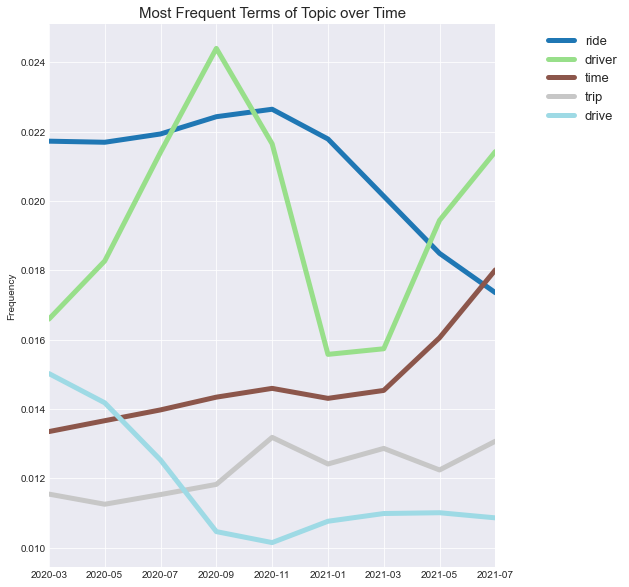

In [172]:
# first topic vis
term_pd = term_pandas(topic[0], 9, top_terms)
top_topics = get_top_terms(term_pd,9, 10)
topic_vis(top_topics, Time_str,9)

less than 10!


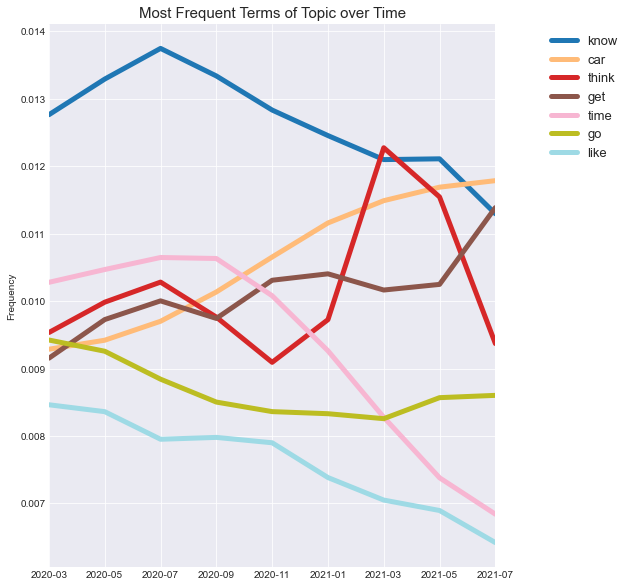

In [173]:
# second topics vis
term_pd = term_pandas(topic[1], 9, top_terms)
top_topics = get_top_terms(term_pd,9, 10)
topic_vis(top_topics, Time_str,9)

less than 10!


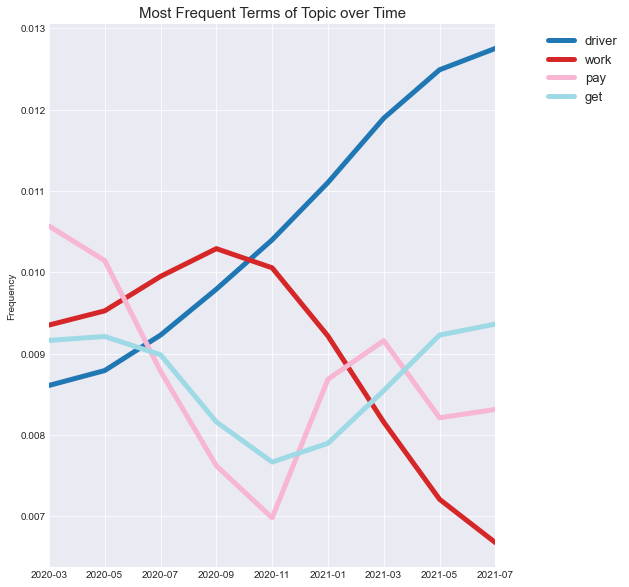

In [174]:
# thirs topics vis
term_pd = term_pandas(topic[2], 9, top_terms)
top_topics = get_top_terms(term_pd,9, 10)
topic_vis(top_topics, Time_str,9)

less than 10!


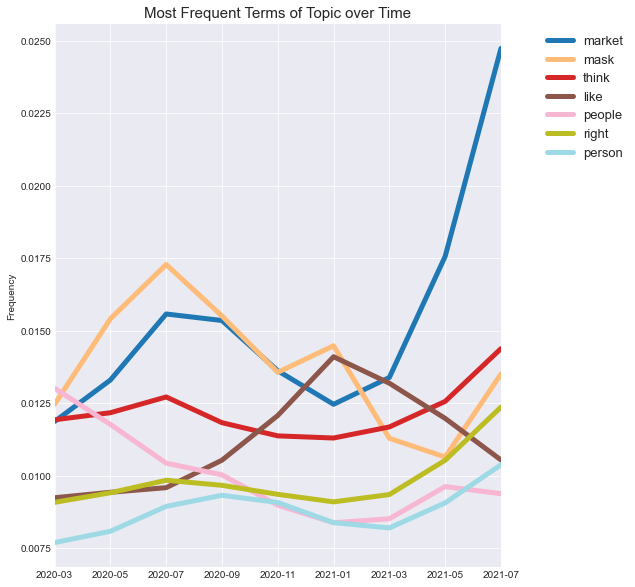

In [175]:
# forth topics vis
term_pd = term_pandas(topic[3], 9, top_terms)
top_topics = get_top_terms(term_pd,9, 10)
topic_vis(top_topics, Time_str,9)

less than 10!


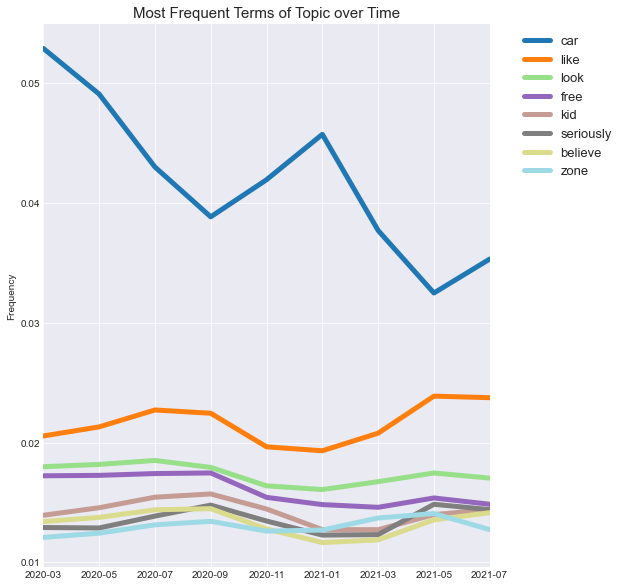

In [176]:
# fifth topics vis
term_pd = term_pandas(topic[4], 9, top_terms)
top_topics = get_top_terms(term_pd,9, 10)
topic_vis(top_topics, Time_str,9)